In [1]:
#This part of the project focuses on identifying fake jobs using the following dataset from kaggle: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction.
#This code is also inspired by the idea of Shivam Burnwal (2020)

#import

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
#still import and install

!pip install missingno
!pip install plotly.express
!pip install wordcloud
!pip install spacy
!pip install xgboost
!pip install -U spacy[lookups]
!pip install imblearn
#!pip install RandomUnderSampler
!pip install spacy
!pip install wordcloud
!pip install sklearn
!pip install -U scikit-learn

import re
import string
import random
import missingno
import en_core_web_sm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.lang.en.examples import sentences

import imblearn
from imblearn.under_sampling import RandomUnderSampler

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

Requirement already up-to-date: spacy[lookups] in c:\users\gv\anaconda3\lib\site-packages (3.4.1)
Requirement already up-to-date: scikit-learn in c:\users\gv\anaconda3\lib\site-packages (1.1.2)


In [3]:
data = pd.read_csv('C:\\mun_fake_job_postings.csv')
print(data)

       job_id                                              title  \
0           1                                   Marketing Intern   
1           2          Customer Service - Cloud Video Production   
2           3            Commissioning Machinery Assistant (CMA)   
3           4                  Account Executive - Washington DC   
4           5                                Bill Review Manager   
...       ...                                                ...   
17875   17876                   Account Director - Distribution    
17876   17877                                 Payroll Accountant   
17877   17878  Project Cost Control Staff Engineer - Cost Con...   
17878   17879                                   Graphic Designer   
17879   17880                         Web Application Developers   

                   location   department salary_range  \
0          US, NY, New York    Marketing          NaN   
1            NZ, , Auckland      Success          NaN   
2           

In [4]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
data.describe()

#Interpreting the data, the columns "telecommuting", "has_company_logo" and "has_questions" may be removed.
#We can also see that only ~0.05% of the dataset consists of fraudulent/fake jobs, which calls for a need for oversampling/undersampling. In this code, oversampling was used.

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#Removing of irrelevant columns and replacing null values

columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del data[col]

data.fillna(' ', inplace=True)

In [7]:
#Spliting of data

def split(location):
    l = location.split(',')
    return l[0]

data['country'] = data.location.apply(split)

Text(0.5, 0, 'Countries')

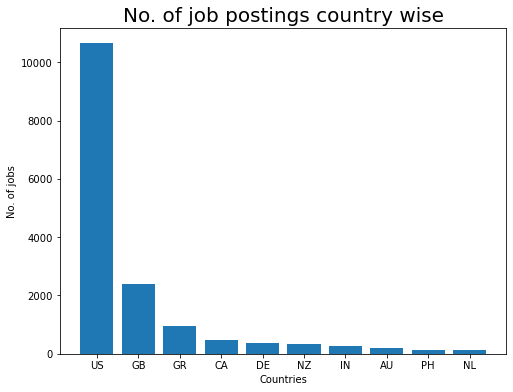

In [8]:
country = dict(data.country.value_counts()[:11])
del country[' ']
plt.figure(figsize=(8,6))
plt.title('No. of job postings country wise', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

#We can see in this graph that the dataset mostly represents the US.
#Thus, given this dataset, predictions may be inaccurate when applied in the Philippines.
#However, this can be easily remedied by training this model with a dataset focused on jobs in the Philippines, once that dataset is available.

In [9]:
#Merging of data

data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']
del data['title']
del data['location']
del data['department']
del data['company_profile']
del data['description']
del data['requirements']
del data['benefits']
del data['required_experience']
del data['required_education']
del data['industry']
del data['function']
del data['country']

data.head()

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."


In [10]:
#Wordcloud visualization

fraudjobs_text = data[data.fraudulent==1].text
actualjobs_text = data[data.fraudulent==0].text

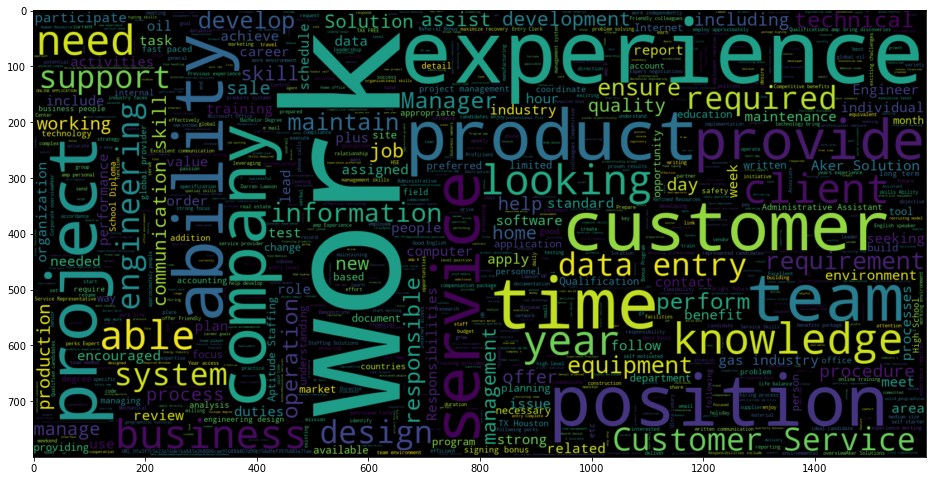

In [11]:
#Wordcloud - Fraudulent Jobs

STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

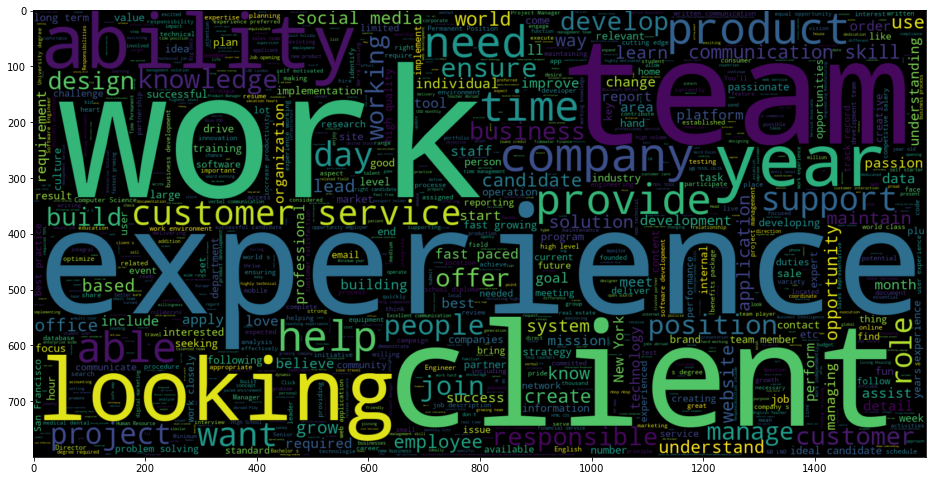

In [12]:
#Wordcloud - Real Jobs

plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

In [13]:
#Cleaning Data

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = en_core_web_sm.load()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [14]:
# Custom transformer using spacy

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Function to clean text
def clean_text(text):
    return text.strip().lower()

In [15]:
#Generation of matrix of occurence of words

#bow_vector = CountVectorizer(min_df=0, max_df=1, binary=False, tokenizer = spacy_tokenizer, ngram_range=(1,3))
bow_vector = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')
#bow_vector.build_analyzer()
#bow_vector.fit_transform(smallcorp.split('\n'))

In [16]:
#Splitting of dataset into training and test sets + Oversampling

X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.3)

'''
under = RandomUnderSampler(sampling_strategy=1)
print("Before oversampling: ",Counter(y_train))
X_train, y_train = under.fit_resample(X_train, y_train)
print("After oversampling: ",Counter(y_train))
X_test, y_test = under.fit_resample(X_test, y_test)

under = RandomUnderSampler(sampling_strategy=1)
X, y = under.fit_resample(X, y)
'''

'\nunder = RandomUnderSampler(sampling_strategy=1)\nprint("Before oversampling: ",Counter(y_train))\nX_train, y_train = under.fit_resample(X_train, y_train)\nprint("After oversampling: ",Counter(y_train))\nX_test, y_test = under.fit_resample(X_test, y_test)\n\nunder = RandomUnderSampler(sampling_strategy=1)\nX, y = under.fit_resample(X, y)\n'

In [17]:
#Logistic Regression Model

#bow_vector_train_reviews = bow_vector.fit_transform(X_train)
#bow_vector_test_reviews = bow_vector.transform(X_test)

clf = LogisticRegression()

# Create pipeline
pipe = Pipeline([('cleaner', predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# Fitting our model
pipe.fit(X_train, y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x0000026E92700D60>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(2, 2),
                                 token_pattern='(?u)\\b\\w+\\b')),
                ('classifier', LogisticRegression())])

In [18]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))
print("Logistic Regression Recall:", recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9847129008202834
Logistic Regression Recall: 0.684


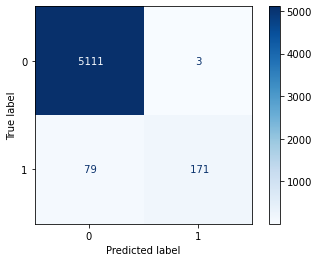

In [20]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')